In [1]:
%matplotlib inline
import numpy as np
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from xgboost import XGBClassifier
import seaborn as sns 

sns.set(style="white")


/home/mickael/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Load training data
nrows_train = 3000000
nrows_test = 50
xtrain = pd.read_csv('InputData/xtrain_challenge.csv', nrows = nrows_train + nrows_test)
ytrain = pd.read_csv('InputData/ytrain_challenge.csv', nrows = nrows_train + nrows_test)
ytrain = np.array(ytrain).reshape(nrows_train + nrows_test)
# Check the number of observations and properties
print(xtrain.head(10))
print(ytrain[:10])
print(xtrain.shape)
print(ytrain.shape)



    fA1   fA2  fA3  fA4  fA5  fA6  fA7   fA8   fA9  fA10   ...    fB13  \
0  3.77  1.00  1.0   41  1.0  0.0  0.0 -0.17  0.03  0.00   ...    0.04   
1  1.47  0.01  0.0   62  1.0  0.0  0.0  0.30  0.02 -0.01   ...    0.01   
2  4.93  1.00  0.0   21  1.0  0.0  0.0  0.00  0.16  0.00   ...    0.07   
3  3.89  1.00  0.0   20  1.0  0.0  0.0 -0.35  0.09 -0.01   ...    0.10   
4  3.15  0.00  0.0   28  1.0  0.0  0.0  0.08 -0.08 -0.01   ...    0.01   
5  1.02  0.00  0.0   28  0.2  0.8  0.0 -0.73  0.00  0.03   ...    0.00   
6  1.28  1.00  0.0   21  1.0  0.0  0.0 -0.01 -0.01  0.00   ...   -0.06   
7  4.55  1.00  0.0   21  1.0  0.0  0.0  0.01 -0.13  0.00   ...   -0.02   
8  1.96  0.98  0.0   20  1.0  0.0  0.0  0.00  0.02  0.00   ...    0.01   
9  3.50  0.01  0.0   25  1.0  0.0  0.0  0.00  0.03  0.00   ...    0.00   

     fB14      s1      s2      s3      s4      s5      s6      s7      s8  
0  271.80  2464.1  2117.2  1760.6  2241.3  1900.3  1462.8  2344.9  1949.8  
1  157.15  3975.9  2640.9  2672.6

# Data Exploration

In [260]:
mask_match = (ytrain == 1)

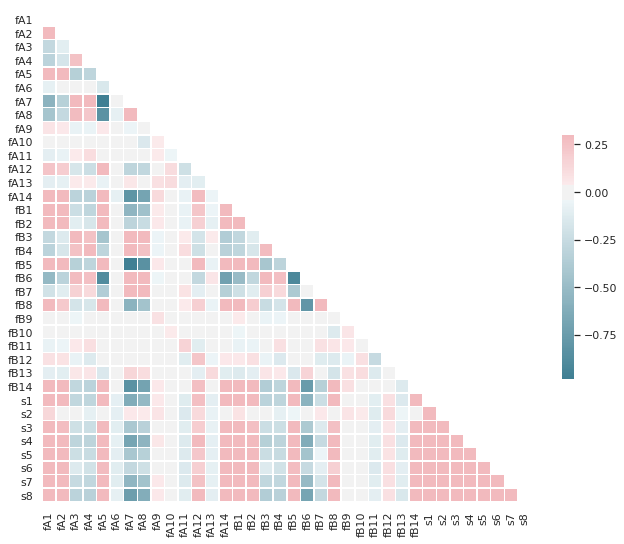

In [261]:
# Correlation matrix
corr = xtrain[mask_match].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

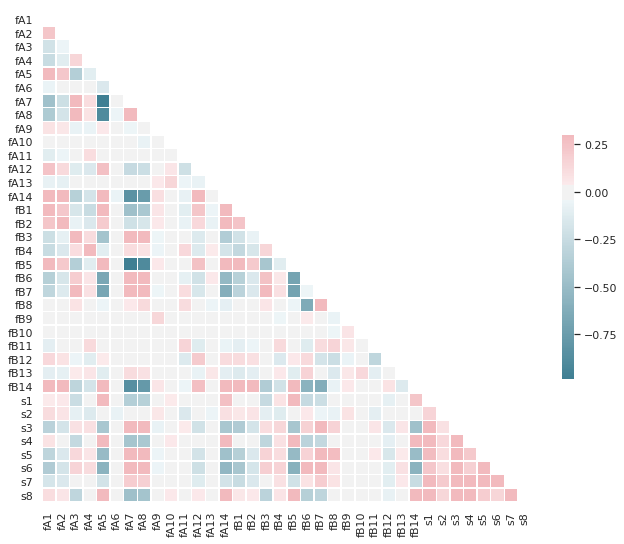

In [262]:
# Correlation matrix
corr = xtrain[~mask_match].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Y a t il des images vecteurs recurrents dans le dataset ? 

In [3]:
cols_A= ["fA1","fA2","fA3","fA4","fA5","fA6","fA7",
           "fA8","fA9","fA10","fA11","fA12","fA13","fA14"]
cols_B= ["fB1","fB2","fB3","fB4","fB5","fB6","fB7",
           "fB8","fB9","fB10","fB11","fB12","fB13","fB14"]
cols_s= ["s1","s2","s3","s4","s5","s6","s7","s8"]
cols_feat = cols_A + cols_B

In [4]:
df1 = pd.DataFrame(xtrain[cols_A].values)
df2 = pd.DataFrame(xtrain[cols_B].values)
x_feat = pd.concat([df1,df2],ignore_index = True)

In [52]:
sum(x_feat.duplicated())

885535

In [55]:
sum(df2.duplicated())

440364

In [63]:
# Numebr of  duplicated match between feat A and B
sum(xtrain[cols_feat].duplicated())

412

81241

In [14]:
print("Size of dataset : {} rows". format(xtrain["fA1"].count())) 
print("# of unique values for feat A: {}".format(df1.drop_duplicates().shape[0]))
print("# of unique values for feat B: {}".format(df2.drop_duplicates().shape[0]))
print("# of feat A values that appears one time: {}".format(sum(df1.duplicated(keep=False)==False)))
print("# of feat A values that appears one time: {}".format(sum(df2.duplicated(keep=False)==False)))
print("# of unique feat values for both A and B: {}".format(sum(x_feat.duplicated(keep=False)==False)))
print("# of unique (featA,featB) values: {}".format(sum(xtrain[cols_feat].duplicated(keep=False)==False)))
print("# of rows where feat A = feat B : {}".format(sum((df1 == df2).all(1))))
print("# of times there is same comparison of (featA, featB): {}".format(
sum(xtrain[cols_feat].duplicated(keep=False))))

Size of dataset : 3000050 rows
# of unique values for feat A: 81241
# of unique values for feat B: 62451
# of feat A values that appears one time: 158
# of feat A values that appears one time: 149
# of unique feat values for both A and B: 307
# of unique (featA,featB) values: 2970827
# of rows where feat A = feat B : 2
# of times there is same comparison of (featA, featB): 29223


Let's go further on the one featA and featB that reappear several times. Our goals is to see if for identical feat A and feat B we also have the same vector function and comparison results. 

In [132]:
mask_duplicate_featAB = xtrain[cols_feat].duplicated(keep=False)
mask2 = xtrain[mask_duplicate_featAB][cols_s].duplicated(keep=False) == False

In [137]:
xtrain[mask_duplicate_featAB][mask2]

,fA1,fA2,fA3,fA4,fA5,fA6,fA7,fA8,fA9,fA10,...,fB13,fB14,s1,s2,s3,s4,s5,s6,s7,s8
85791,3.82,0.0,0.0,28,1.0,0.0,0.0,0.03,-0.12,0.00,...,-0.05,278.39,2140.6,1914.4,1681.1,2803.4,2415.8,2351.1,2676.8,2486.4
190370,2.69,0.0,0.0,33,1.0,0.0,0.0,0.26,0.02,0.02,...,-0.01,302.43,6871.1,2319.7,9033.0,8213.0,5461.3,5212.1,5005.3,6713.8
274109,2.69,0.0,0.0,33,1.0,0.0,0.0,0.26,0.02,0.02,...,-0.01,302.43,6871.1,2319.7,9030.5,8213.0,5461.5,5212.6,5005.3,6713.8
284165,3.82,0.0,0.0,28,1.0,0.0,0.0,0.03,-0.12,0.00,...,-0.05,278.39,2140.6,1914.4,1681.0,2803.4,2415.8,2351.2,2676.8,2486.4
299831,3.53,0.0,0.0,41,1.0,0.0,0.0,0.04,-0.03,0.00,...,-0.05,278.39,2613.2,2115.9,1962.9,3187.4,2838.7,1847.0,2601.6,2735.4
422421,3.53,0.0,0.0,41,1.0,0.0,0.0,0.04,-0.03,0.00,...,-0.05,278.39,2613.2,2115.9,1963.1,3187.4,2838.6,1847.0,2601.6,2735.4


When we look at the difference in sx, there is small variation (when we compare at the entire values) of sx values for featA,featB identical. Therefore, we could conclude that for featA and featB identical , the values sx are identicals.

In [146]:
a =  xtrain[mask_duplicate_featAB]
a["match"] = ytrain[mask_duplicate_featAB]

/home/mickael/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [160]:
sum(a.groupby(cols_feat)["match"].agg({"max","min"})["max"] != a.groupby(cols_feat)["match"].agg({"max","min"})["min"])

0

For some identical rows, the results is "match/unmacth" results is the same

In [174]:
xtrain[mask_match][["fA13","fB13","fA14","fB14","fA12","fB12"]]

,fA13,fB13,fA14,fB14,fA12,fB12
5,0.23,0.00,138.30,295.79,0.00,0.04
12,0.01,0.00,238.57,255.78,-0.07,0.08
16,-0.04,-0.08,357.73,305.72,0.27,0.22
17,-0.06,-0.10,292.28,191.35,0.01,0.13
18,-0.06,-0.03,365.59,308.90,0.08,-0.01
22,-0.07,0.09,412.72,258.39,0.10,-0.09
25,0.04,-0.07,262.51,235.45,0.02,-0.05
27,-0.01,0.02,-36.58,-75.94,-0.13,-0.14
29,-0.05,-0.07,313.14,174.44,0.00,0.07
32,0.02,0.00,354.02,298.87,0.10,0.28


# Feature engineering

In [296]:
i = 1
s = f"test{i}"
s

'test1'

In [297]:
for i in np.arange(1,15): 
    xtrain[f"diff{i}"]=xtrain[f"fA{i}"]-xtrain[f"fB{i}"]

In [299]:
xtrain.head()

,fA1,fA2,fA3,fA4,fA5,fA6,fA7,fA8,fA9,fA10,...,diff5,diff6,diff7,diff8,diff9,diff10,diff11,diff12,diff13,diff14
0,3.77,1.00,1.0,41,1.0,0.0,0.0,-0.17,0.03,0.00,...,0.0,0.0,0.0,-0.26,-0.21,-0.01,0.07,0.04,-0.05,-70.21
1,1.47,0.01,0.0,62,1.0,0.0,0.0,0.30,0.02,-0.01,...,0.0,0.0,0.0,0.34,0.12,-0.03,0.00,-0.05,-0.07,21.87
2,4.93,1.00,0.0,21,1.0,0.0,0.0,0.00,0.16,0.00,...,0.0,0.0,0.0,0.04,0.16,-0.01,0.02,-0.17,-0.12,90.70
3,3.89,1.00,0.0,20,1.0,0.0,0.0,-0.35,0.09,-0.01,...,0.0,0.0,0.0,-0.27,0.05,-0.02,-0.04,0.11,-0.07,21.76
4,3.15,0.00,0.0,28,1.0,0.0,0.0,0.08,-0.08,-0.01,...,0.0,0.0,0.0,0.12,-0.09,-0.01,-0.08,0.06,-0.03,-86.54


# Classifier of 0

In [249]:
X_train, X_test, y_train, y_test = train_test_split(xtrain, ytrain, test_size=0.33, random_state=42)


In [263]:
# Let's try some feature engineering via choosing some columns 
cols_to_keep1 = ["fA1","fA2","fA3","fA4","fA5","fA6","fA7",
           "fA8","fA14","fB1","fB2","fB3","fB4","fB5","fB6","fB7",
           "fB8","fB14"] 

In [265]:
clf = RandomForestClassifier(n_estimators=100, max_depth=10,random_state=0)
clf.fit(X_train[cols_to_keep1],y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [270]:
hard = clf.predict(X_test[cols_to_keep1])
soft = clf.predict_proba(X_test[cols_to_keep1])

In [278]:
# Xgboost classifier 
xgb = XGBClassifier(n_jobs = -1 , learning_rate = 0.8
                    , n_estimators = 1024 )
%time xgb.fit(X_train,y_train)

CPU times: user 40min 15s, sys: 9.96 s, total: 40min 25s
Wall time: 11min 13s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.8, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1024,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [333]:
hard = xgb.predict(X_train)
soft = xgb.predict_proba(X_train)

In [252]:
pd.DataFrame(confusion_matrix(y_test,hard), 
             columns = ["Predict 0", "Predict 1"], 
             index = ["Real 0", "Real 1"])

,Predict 0,Predict 1
Real 0,234940,773
Real 1,7975,86329


In [281]:
fpr, tpr, _ = roc_curve(y_test,soft[:,0], pos_label = 0)

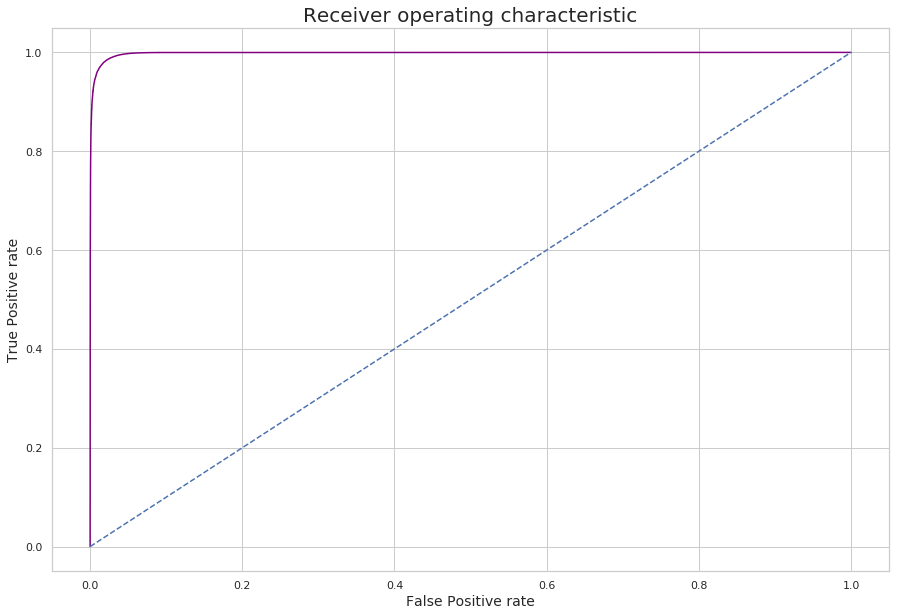

In [282]:
fig = plt.figure( figsize = (15,10))
sns.set(style = "whitegrid")
plt.plot(fpr, tpr, label = "ROC Curve", color = "purple")
plt.plot([0,1],[0,1], linestyle = "--")
plt.xlabel("False Positive rate", fontsize=14)
plt.ylabel("True Positive rate", fontsize=14)
plt.title('Receiver operating characteristic', fontsize = 20)
plt.show()

In [256]:
def confusion_matrix_rate(ytrue, ypred_proba, proba_limit = 0.5):
    # We assume that first column of ypred represents the 0 proba 
    # And the second column represent the 1 proba 
    proba_0 = ypred_proba[:,0]
    ypred_reco = [0 if x>proba_limit else 1 for x in proba_0]
    ypred_reco = np.asarray(ypred_reco)
    df = pd.DataFrame(confusion_matrix(ytrue,ypred_reco), 
             columns = ["Predict 0", "Predict 1"], 
             index = ["Real 0", "Real 1"])
    mask_predict_0 = (ypred_reco==0)
    n = len(ytrue)
    num_pred0 = sum(ypred_reco==0)
    num_true0_onpred0 = sum(ytrue[mask_predict_0]==0)
    print("Precision of 0 in our dataset is {}".format(num_true0_onpred0/num_pred0))
    print("For this precision level, we predict {}% of the dataset".format(num_pred0/n *100))
    print(df)

In [388]:
confusion_matrix_rate(y_train,soft, proba_limit=0.999)

Precision of 0 in our dataset is 0.9999674603830163
For this precision level, we predict 59.62586917360787% of the dataset
        Predict 0  Predict 1
Real 0     399500      79495
Real 1         13     191025


In [300]:
summary=pd.DataFrame([["rf","all",0.95,0.99706,59.855],
                     ["rf","cols_1",0.90,0.9575,18.004],
                     ["xgb","all",0.99,0.998389,65.86]],
                     columns = ["class","feature_set","ProbaSep","Precision on 0","Percentage of 0"])

In [301]:
summary.head()

,class,feature_set,ProbaSep,Precision on 0,Percentage of 0
0,rf,all,0.95,0.997060,59.855
1,rf,cols_1,0.90,0.957500,18.004
2,xgb,all,0.99,0.998389,65.860


## Separate the predicted 0 from the set

In [417]:
def separate0Prediction(ysoft, ProbaCriteria): 
    proba_0 = ysoft[:,0]
    mask = proba_0>ProbaCriteria
    return mask, np.argwhere(mask).ravel()
def secondTrainingset(xtrain, ytrain, ysoft_train, ProbaCriteria):
    proba_0 = ysoft_train[:,0]
    mask = proba_0<ProbaCriteria
    return xtrain.iloc[mask], ytrain[mask]
def FilterTestingSet(ypred_final, ysoft_test, ProbaCriteria):
    proba_0 = ysoft_test[:,0]
    mask = proba_0<ProbaCriteria
    ypred_final.iloc[~mask]["y"] = 0 
    idx0 = np.argwhere(~mask).ravel()
    return  ypred_final.iloc[mask].drop(["y"],axis=1), ypred_final, idx0

## create a new training set focus on detecting the 1

In [355]:
# Reset index of train and test for issue purpose
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [378]:
hard_tr = xgb.predict(X_train)
soft_tr = xgb.predict_proba(X_train)

In [441]:
X_train2, y_train2 = secondTrainingset(X_train, y_train, soft_tr, 0.999)

Take out the "almost sure" 0 from the testing set

In [427]:
ypred_final = X_test.copy()

In [429]:
ypred_final["y"]=np.nan

In [397]:
hard_test1 = xgb.predict(X_test)
soft_test1 = xgb.predict_proba(X_test)

In [400]:
confusion_matrix_rate(y_test,soft_test1, proba_limit=0.999)

Precision of 0 in our dataset is 0.9994908713228181
For this precision level, we predict 59.516327946742145% of the dataset
        Predict 0  Predict 1
Real 0     196314      39399
Real 1        100      94204


In [418]:
Xtest2 , ypred_final , idx0 = FilterTestingSet(ypred_final, soft_test1, 0.999)

/home/mickael/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [421]:
Xtest2.head()

,fA1,fA2,fA3,fA4,fA5,fA6,fA7,fA8,fA9,fA10,...,fB13,fB14,s1,s2,s3,s4,s5,s6,s7,s8
2,4.67,0.00,0.0,30,1.0,0.0,0.0,0.00,-0.01,0.00,...,-0.03,199.11,4430.4,2896.4,6102.3,5137.0,3788.2,3400.9,3767.1,4269.2
3,2.27,0.00,0.0,23,1.0,0.0,0.0,-0.10,0.24,-0.03,...,-0.08,205.64,5504.4,2418.9,3474.3,5919.3,4164.2,4353.8,3935.7,4906.9
5,0.83,0.01,0.0,26,1.0,0.0,0.0,0.00,-0.04,0.00,...,-0.02,272.21,5368.3,2524.9,7333.4,5660.2,3687.1,3214.8,4000.4,4909.1
7,4.65,1.00,0.0,20,1.0,0.0,0.0,0.11,0.07,-0.01,...,-0.04,294.48,7230.9,2711.5,8619.3,8330.2,6147.8,5054.3,5354.3,6489.4
14,3.78,1.00,0.0,23,1.0,0.0,0.0,0.40,-0.07,-0.04,...,-0.04,300.27,6824.9,2725.4,10328.5,7855.8,5821.6,5481.2,5311.3,6564.5


2nd Classifier

In [448]:
# Random Forest
clf2 = RandomForestClassifier(n_estimators=100, max_depth=10,random_state=0)
clf2.fit(X_train2,y_train2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [443]:
# 2nd Xgboost 
xgb2 = XGBClassifier(n_jobs = -1 , learning_rate = 0.8
                    , n_estimators = 1024 )
%time xgb2.fit(X_train2,y_train2)

CPU times: user 11min 37s, sys: 2.58 s, total: 11min 39s
Wall time: 3min 7s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.8, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1024,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [449]:
hard_test1 = clf2.predict(Xtest2)
soft_test1 = clf2.predict_proba(Xtest2)

In [450]:
y_true2 = y_test[Xtest2.index]

In [458]:
confusion_matrix_rate(y_true2,soft_test1, proba_limit=0.90)

Precision of 0 in our dataset is 0.9805044608437052
For this precision level, we predict 6.795506088935128% of the dataset
        Predict 0  Predict 1
Real 0       8902      30497
Real 1        177      94027


In [452]:
mask_match2 = (y_train2 == 1)

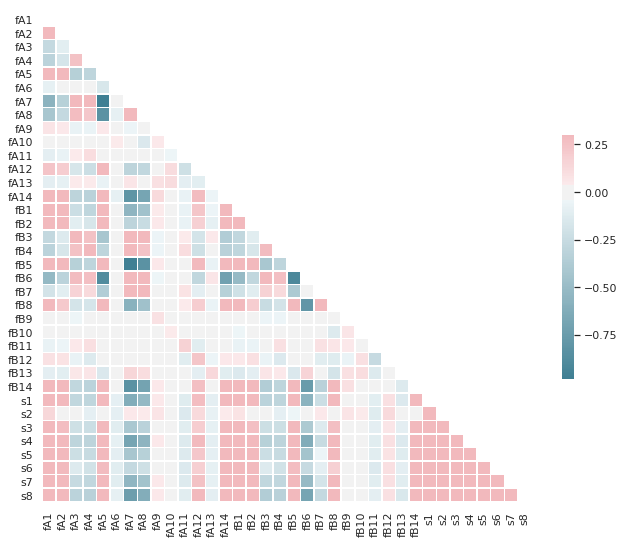

In [454]:
# Correlation matrix
corr = X_train2[mask_match2].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

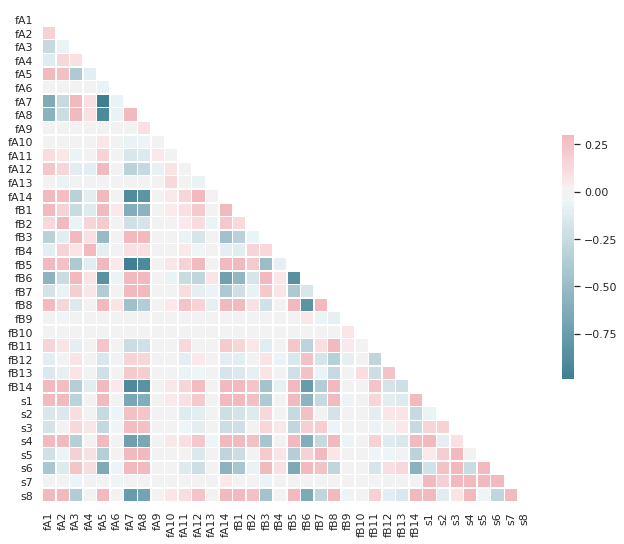

In [455]:
# Correlation matrix
corr = X_train2[~mask_match2].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [460]:
df12 = pd.DataFrame(X_train2[cols_A].values)
df22 = pd.DataFrame(X_train2[cols_B].values)
x_feat = pd.concat([df12,df22],ignore_index = True)

In [461]:
print("Size of dataset : {} rows". format(X_train2["fA1"].count())) 
print("# of unique feat A values: {}".format(sum(df12.duplicated(keep=False)==False)))
print("# of unique feat B values: {}".format(sum(df22.duplicated(keep=False)==False)))
print("# of unique feat values for both A and B: {}".format(sum(x_feat.duplicated(keep=False)==False)))
print("# of unique (featA,featB) values: {}".format(sum(X_train2[cols_feat].duplicated(keep=False)==False)))
print("# of rows where feat A = feat B : {}".format(sum((df12 == df22).all(1))))
print("# of times there is same comparison of (featA, featB): {}".format(
sum(X_train2[cols_feat].duplicated(keep=False))))

Size of dataset : 270520 rows
# of unique feat A values: 16625
# of unique feat B values: 10960
# of unique feat values for both A and B: 24881
# of unique (featA,featB) values: 270324
# of rows where feat A = feat B : 1
# of times there is same comparison of (featA, featB): 196


In [463]:
# Load from file
import pickle
pkl_filename = "xgboost_stage1_model.pkl"
with open(pkl_filename, 'rb') as file:  
    pickle_model = pickle.load(file)


In [464]:
pickle_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.8, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=nan, n_estimators=1024,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)